In [1]:
!pip install tensorflow numpy matplotlib scikit-learn scipy requests tqdm opencv-python

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import json
import os
from tensorflow.keras import layers, models, optimizers, callbacks
import warnings
import gc

warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
tf.config.experimental.set_memory_growth(tf.config.list_physical_devices('GPU')[0], True) if tf.config.list_physical_devices('GPU') else None

def eliberare_memorie():
    gc.collect()
    tf.keras.backend.clear_session()
    print("Memoria a fost eliberata manual")

IMG_SIZE = 224
BATCH_SIZE = 32
NUM_EPOCI = 100

SEED = 2025
np.random.seed(SEED)
tf.random.set_seed(SEED)

print('Mediul de lucru:')
print(f'TensorFlow: {tf.__version__}')
print(f'GPU disponibil: {"DA" if tf.config.list_physical_devices("GPU") else "NU"}')

Mediul de lucru:
TensorFlow: 2.18.0
GPU disponibil: DA


In [3]:
def încarcă_dataset_flori():

    import tensorflow_datasets as tfds

    dataset, info = tfds.load('oxford_flowers102', as_supervised=True, with_info=True)

    train_set = dataset['test']
    val_set = dataset['validation']
    test_set = dataset['train']

    num_train = info.splits['test'].num_examples
    num_val = info.splits['validation'].num_examples
    num_test = info.splits['train'].num_examples
    num_classes = info.features['label'].num_classes

    print('Statistici dataset:')
    print(f'Total clase: {num_classes}')
    print(f'Exemple antrenare: {num_train}')
    print(f'Exemple validare: {num_val}')
    print(f'Exemple testare: {num_test}')

    try:
        with open('label_map.json', 'r') as f:
            class_names = json.load(f)
    except:
        class_names = {str(i): f'Flower_{i}' for i in range(num_classes)}
        with open('label_map.json', 'w') as f:
            json.dump(class_names, f)

    return (train_set, val_set, test_set), info, num_classes, class_names

(train_set, val_set, test_set), dataset_info, num_classes, class_names = încarcă_dataset_flori()
eliberare_memorie()

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_flowers102/incomplete.P1FFIO_2.1.1/oxford_flowers102-train.tfrecord…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_flowers102/incomplete.P1FFIO_2.1.1/oxford_flowers102-test.tfrecord*…

Generating validation examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_flowers102/incomplete.P1FFIO_2.1.1/oxford_flowers102-validation.tfr…

Dataset oxford_flowers102 downloaded and prepared to /root/tensorflow_datasets/oxford_flowers102/2.1.1. Subsequent calls will reuse this data.
Statistici dataset:
Total clase: 102
Exemple antrenare: 6149
Exemple validare: 1020
Exemple testare: 1020
Memoria a fost eliberata manual


Memoria a fost eliberata manual


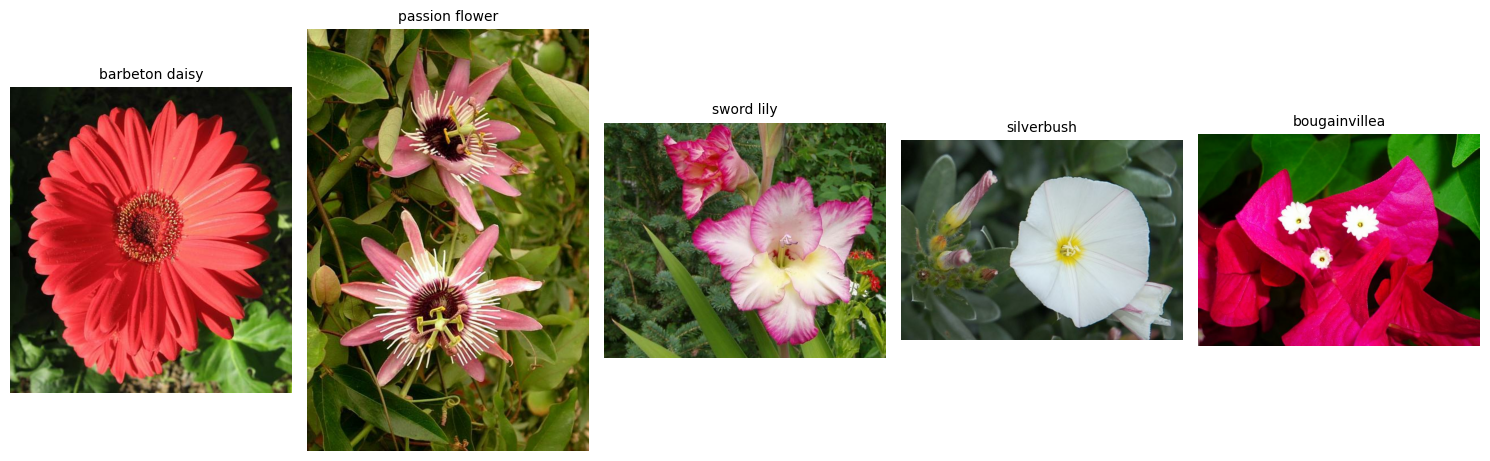

In [4]:
def normalizare_imagine(imagine, etichetă):
    imagine = tf.cast(imagine, tf.float32) / 255.0

    imagine = tf.image.resize(imagine, [IMG_SIZE, IMG_SIZE])

    return imagine, etichetă

def augmentare_simplă(img, label):
    img = tf.image.random_flip_left_right(img)
    img = tf.image.random_flip_up_down(img)

    img = tf.image.rot90(img, k=tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32))

    img = tf.image.random_brightness(img, 0.2)
    img = tf.image.random_contrast(img, 0.8, 1.2)

    return img, label

def creare_pipeline_eficient(set_date, batch_size, shuffle_size=1000, este_antrenare=False):

    set_date = set_date.map(normalizare_imagine, num_parallel_calls=tf.data.AUTOTUNE)

    if este_antrenare:
        set_date = set_date.map(augmentare_simplă, num_parallel_calls=tf.data.AUTOTUNE)

    if este_antrenare and shuffle_size > 0:
        set_date = set_date.shuffle(shuffle_size)

    set_date = set_date.batch(batch_size)
    set_date = set_date.prefetch(tf.data.AUTOTUNE)

    return set_date

train_batches = creare_pipeline_eficient(train_set, BATCH_SIZE, shuffle_size=1000, este_antrenare=True)
val_batches = creare_pipeline_eficient(val_set, BATCH_SIZE)
test_batches = creare_pipeline_eficient(test_set, BATCH_SIZE)

eliberare_memorie()

def vizualizează_imagini_dataset(set_date, class_names, num_imagini=5):
    numele_florilor = [
        "pink primrose", "hard-leaved pocket orchid", "canterbury bells", "sweet pea",
        "english marigold", "tiger lily", "moon orchid", "bird of paradise", "monkshood",
        "globe thistle", "snapdragon", "colt's foot", "king protea", "spear thistle",
        "yellow iris", "globe-flower", "purple coneflower", "peruvian lily", "balloon flower",
        "giant white arum lily", "fire lily", "pincushion flower", "fritillary",
        "red ginger", "grape hyacinth", "corn poppy", "prince of wales feathers",
        "stemless gentian", "artichoke", "sweet william", "carnation", "garden phlox",
        "love in the mist", "mexican aster", "alpine sea holly", "ruby-lipped cattleya",
        "cape flower", "great masterwort", "siam tulip", "lenten rose", "barbeton daisy",
        "daffodil", "sword lily", "poinsettia", "bolero deep blue", "wallflower",
        "marigold", "buttercup", "oxeye daisy", "common dandelion", "petunia",
        "wild pansy", "primula", "sunflower", "pelargonium", "bishop of llandaff",
        "gaura", "geranium", "orange dahlia", "pink-yellow dahlia", "cautleya spicata",
        "japanese anemone", "black-eyed susan", "silverbush", "californian poppy",
        "osteospermum", "spring crocus", "bearded iris", "windflower", "tree poppy",
        "gazania", "azalea", "water lily", "rose", "thorn apple", "morning glory",
        "passion flower", "lotus", "toad lily", "anthurium", "frangipani", "clematis",
        "hibiscus", "columbine", "desert-rose", "tree mallow", "magnolia", "cyclamen",
        "watercress", "canna lily", "hippeastrum", "bee balm", "ball moss",
        "foxglove", "bougainvillea", "camellia", "mallow", "mexican petunia",
        "bromelia", "blanket flower", "trumpet creeper", "blackberry lily"
    ]

    plt.figure(figsize=(15, 5))

    for i, (img, label) in enumerate(set_date.take(num_imagini)):
        plt.subplot(1, num_imagini, i+1)
        img = img.numpy()
        label = int(label.numpy())

        if label < len(numele_florilor):
            nume_floare = numele_florilor[label]
        else:
            nume_floare = numele_florilor[label-1] if label-1 < len(numele_florilor) else f"Clasa {label}"

        plt.imshow(img)
        plt.title(f'{nume_floare}', fontsize=10)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

vizualizează_imagini_dataset(train_set, class_names)

In [5]:
def creeaza_model_flori_avansat(num_classes):
    tf.keras.backend.clear_session()

    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))

    x = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)

    x = layers.Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)

    x = layers.Conv2D(128, (3, 3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)

    x = layers.Conv2D(256, (3, 3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)

    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    return model

model = creeaza_model_flori_avansat(num_classes)
model.summary()

model.compile(
    optimizer=optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

eliberare_memorie()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 28, 28, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 102)            │        52,326 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 576,294 (2.20 MB)

 Trainable params: 574,310 (2.19 MB)

 Non-trainable params: 1,984 (7.75 KB)

Memoria a fost eliberata manual


Incep antrenarea modelului.
Epoch 1/80
193/193 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.0841 - loss: 4.8247
Epoch 1: val_accuracy improved from -inf to 0.02549, saving model to flori_model_avansat.keras
193/193 ━━━━━━━━━━━━━━━━━━━━ 49s 164ms/step - accuracy: 0.0843 - loss: 4.8223 - val_accuracy: 0.0255 - val_loss: 5.3817 - learning_rate: 0.0010
Epoch 2/80
192/193 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.1824 - loss: 3.6289
Epoch 2: val_accuracy improved from 0.02549 to 0.05196, saving model to flori_model_avansat.keras
193/193 ━━━━━━━━━━━━━━━━━━━━ 24s 109ms/step - accuracy: 0.1825 - loss: 3.6281 - val_accuracy: 0.0520 - val_loss: 4.9434 - learning_rate: 0.0010
Epoch 3/80
192/193 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.2231 - loss: 3.3463
Epoch 3: val_accuracy improved from 0.05196 to 0.15784, saving model to flori_model_avansat.keras
193/193 ━━━━━━━━━━━━━━━━━━━━ 27s 124ms/step - accuracy: 0.2232 - loss: 3.3456 - val_accuracy: 0.1578 - val_loss: 3.6475 - learning_

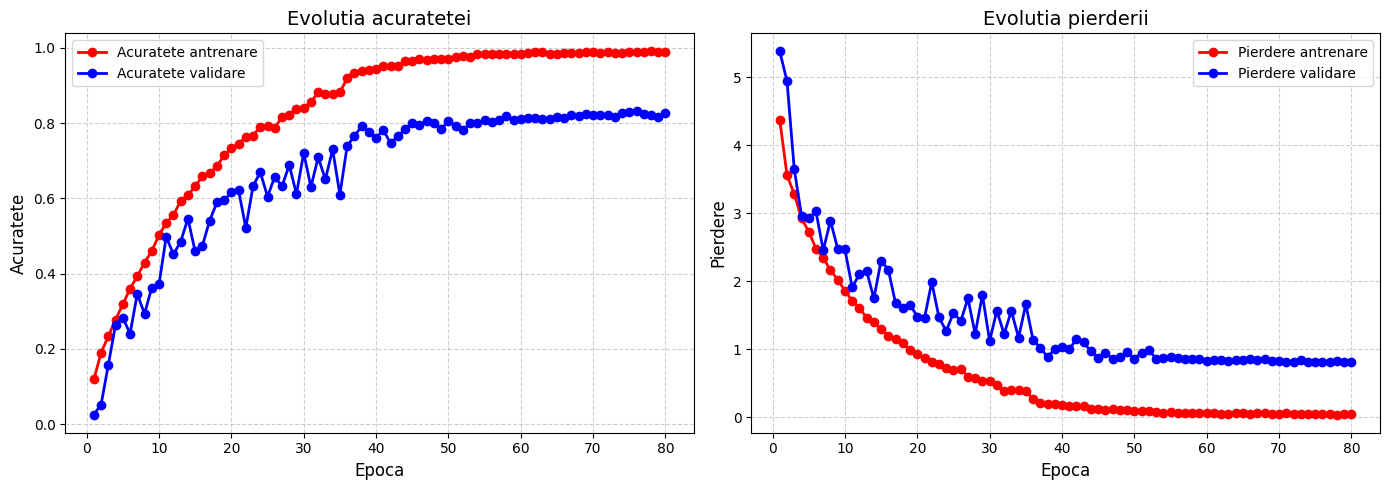

In [6]:
def configurare_callbacks_eficient():
    model_checkpoint = callbacks.ModelCheckpoint(
        'flori_model_avansat.keras',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )

    early_stop = callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=20,
        restore_best_weights=True,
        verbose=1
    )

    reduce_lr = callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=0.00001,
        verbose=1
    )

    return [model_checkpoint, early_stop, reduce_lr]

print("Incep antrenarea modelului.")
history = model.fit(
    train_batches,
    epochs=80,
    validation_data=val_batches,
    callbacks=configurare_callbacks_eficient(),
    verbose=1
)

def vizualizare_istorie_antrenare(istoric):
    acuratete = istoric.history['accuracy']
    val_acuratete = istoric.history['val_accuracy']
    pierdere = istoric.history['loss']
    val_pierdere = istoric.history['val_loss']
    epoci = range(1, len(acuratete) + 1)

    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epoci, acuratete, 'ro-', label='Acuratete antrenare', linewidth=2)
    plt.plot(epoci, val_acuratete, 'bo-', label='Acuratete validare', linewidth=2)
    plt.title('Evolutia acuratetei', fontsize=14)
    plt.xlabel('Epoca', fontsize=12)
    plt.ylabel('Acuratete', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epoci, pierdere, 'ro-', label='Pierdere antrenare', linewidth=2)
    plt.plot(epoci, val_pierdere, 'bo-', label='Pierdere validare', linewidth=2)
    plt.title('Evolutia pierderii', fontsize=14)
    plt.xlabel('Epoca', fontsize=12)
    plt.ylabel('Pierdere', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend()

    plt.tight_layout()
    plt.show()

vizualizare_istorie_antrenare(history)


Evaluez modelul pe setul de testare.
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 81ms/step - accuracy: 0.8063 - loss: 0.9160
Acuratete pe setul de test: 0.8020
Pierdere pe setul de test: 0.8877
Model salvat cu succes!
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 825ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


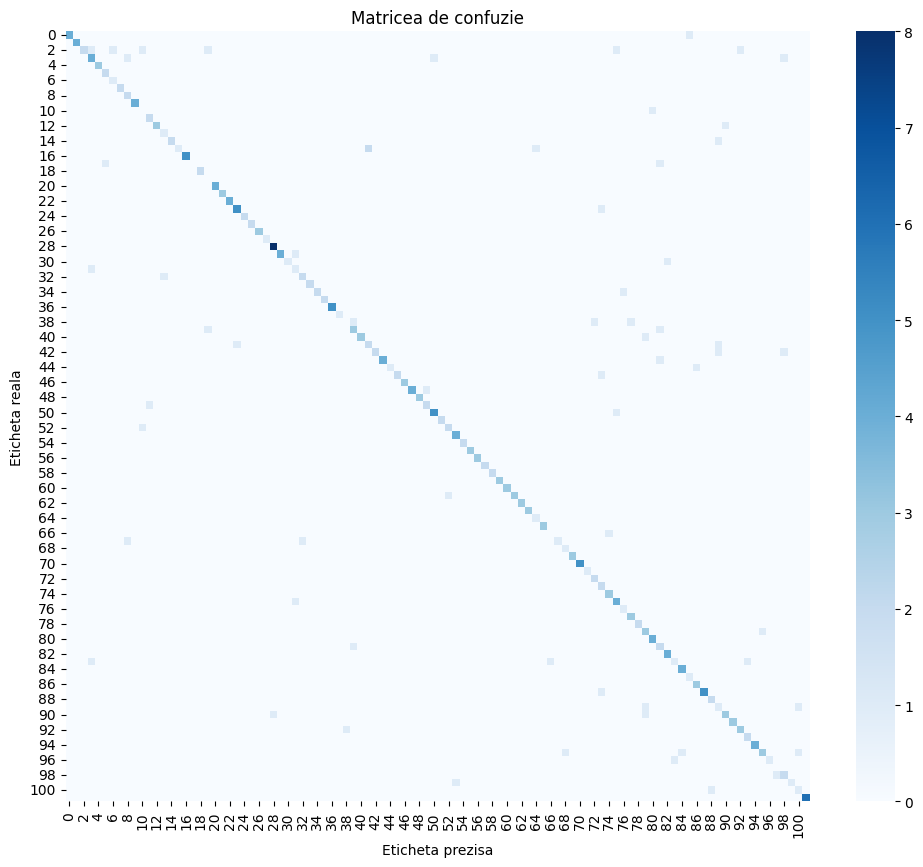

Raport de clasificare:
              precision    recall  f1-score   support

           0       1.00      0.80      0.89         5
           1       1.00      1.00      1.00         4
           2       1.00      0.25      0.40         8
           3       0.57      0.57      0.57         7
           4       1.00      1.00      1.00         3
           5       0.67      1.00      0.80         2
           6       0.50      1.00      0.67         1
           7       1.00      1.00      1.00         2
           8       0.50      1.00      0.67         2
           9       1.00      1.00      1.00         4
          10       0.00      0.00      0.00         1
          11       0.67      1.00      0.80         2
          12       1.00      0.75      0.86         4
          13       0.50      1.00      0.67         1
          14       1.00      0.67      0.80         3
          15       1.00      0.25      0.40         4
          16       1.00      1.00      1.00         5
    

array([[4, 0, 0, ..., 0, 0, 0],
       [0, 4, 0, ..., 0, 0, 0],
       [0, 0, 2, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 0, 6]])

In [8]:
print("\nEvaluez modelul pe setul de testare.")
test_loss, test_acc = model.evaluate(test_batches)
print(f'Acuratete pe setul de test: {test_acc:.4f}')
print(f'Pierdere pe setul de test: {test_loss:.4f}')

model.save('model_flori_avansat.keras')
print("Model salvat cu succes!")

def calculare_matrice_confuzie(model, set_date, clase):
    from sklearn.metrics import confusion_matrix, classification_report
    import seaborn as sns

    predictii = []
    etichete_reale = []

    for imagini, etichete in set_date:
        pred = model.predict(imagini)
        pred_clase = np.argmax(pred, axis=1)

        predictii.extend(pred_clase)
        etichete_reale.extend(etichete.numpy())

    cm = confusion_matrix(etichete_reale, predictii)

    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=False, cmap="Blues")
    plt.title("Matricea de confuzie")
    plt.ylabel("Eticheta reala")
    plt.xlabel("Eticheta prezisa")
    plt.show()

    print("Raport de clasificare:")
    print(classification_report(etichete_reale, predictii))

    return cm

subset_test = test_batches.take(10)
calculare_matrice_confuzie(model, subset_test, num_classes)

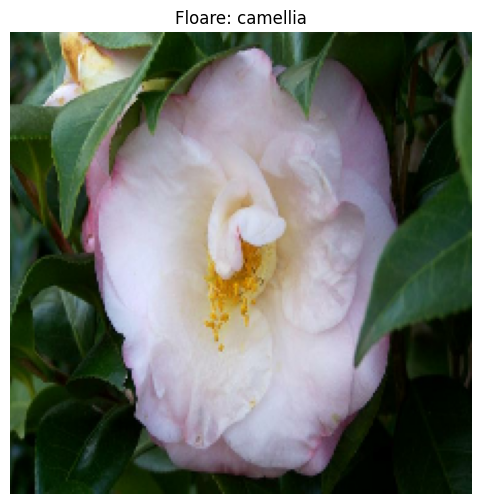

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Floare reala: camellia

Top 3 predictii:
1. camellia - 0.7523
2. japanese anemone - 0.2030
3. hibiscus - 0.0354

Predictie corecta!


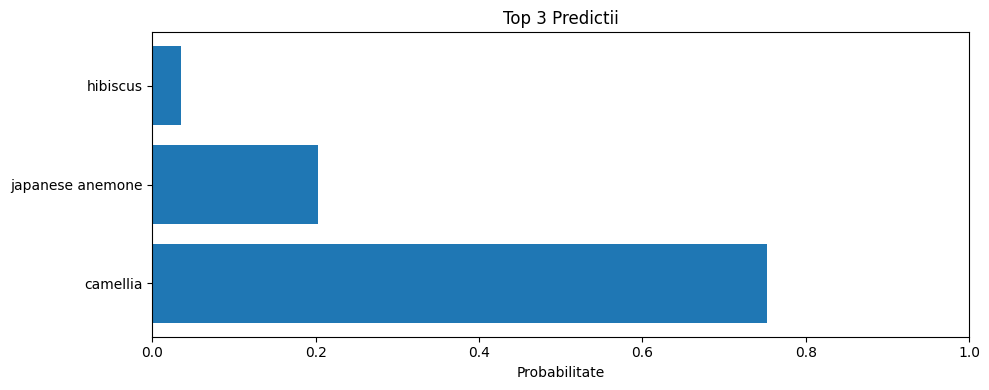

In [9]:
from PIL import Image
import random
import os
import matplotlib.pyplot as plt

numele_florilor = [
        "pink primrose", "hard-leaved pocket orchid", "canterbury bells", "sweet pea",
        "english marigold", "tiger lily", "moon orchid", "bird of paradise", "monkshood",
        "globe thistle", "snapdragon", "colt's foot", "king protea", "spear thistle",
        "yellow iris", "globe-flower", "purple coneflower", "peruvian lily", "balloon flower",
        "giant white arum lily", "fire lily", "pincushion flower", "fritillary",
        "red ginger", "grape hyacinth", "corn poppy", "prince of wales feathers",
        "stemless gentian", "artichoke", "sweet william", "carnation", "garden phlox",
        "love in the mist", "mexican aster", "alpine sea holly", "ruby-lipped cattleya",
        "cape flower", "great masterwort", "siam tulip", "lenten rose", "barbeton daisy",
        "daffodil", "sword lily", "poinsettia", "bolero deep blue", "wallflower",
        "marigold", "buttercup", "oxeye daisy", "common dandelion", "petunia",
        "wild pansy", "primula", "sunflower", "pelargonium", "bishop of llandaff",
        "gaura", "geranium", "orange dahlia", "pink-yellow dahlia", "cautleya spicata",
        "japanese anemone", "black-eyed susan", "silverbush", "californian poppy",
        "osteospermum", "spring crocus", "bearded iris", "windflower", "tree poppy",
        "gazania", "azalea", "water lily", "rose", "thorn apple", "morning glory",
        "passion flower", "lotus", "toad lily", "anthurium", "frangipani", "clematis",
        "hibiscus", "columbine", "desert-rose", "tree mallow", "magnolia", "cyclamen",
        "watercress", "canna lily", "hippeastrum", "bee balm", "ball moss",
        "foxglove", "bougainvillea", "camellia", "mallow", "mexican petunia",
        "bromelia", "blanket flower", "trumpet creeper", "blackberry lily"
    ]

def get_nume_floare(idx):
    if 0 <= idx < len(numele_florilor):
        return numele_florilor[idx]
    elif 1 <= idx <= len(numele_florilor):
        return numele_florilor[idx-1]
    else:
        return f"Floare necunoscuta (Clasa {idx})"

def prelucrare_imagine(cale_imagine):
    imagine = Image.open(cale_imagine)
    imagine = imagine.resize((IMG_SIZE, IMG_SIZE))
    imagine = np.array(imagine) / 255.0
    imagine = np.expand_dims(imagine, axis=0)
    return imagine

def predictie_floare(model, cale_imagine, class_names, top_k=5):
    img = prelucrare_imagine(cale_imagine)

    predictions = model.predict(img)

    top_indices = np.argsort(predictions[0])[-top_k:][::-1]
    top_probs = predictions[0][top_indices]

    top_classes = [class_names.get(str(idx), f"Clasa {idx}") for idx in top_indices]

    return top_probs, top_indices, top_classes

def vizualizare_predictie(model, cale_imagine, class_names):
    probs, indices, classes = predictie_floare(model, cale_imagine, class_names)

    img = Image.open(cale_imagine)

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title(f'Predicție: {classes[0]}', fontsize=14)
    plt.axis('off')

    plt.subplot(1, 2, 2)
    y_pos = np.arange(len(classes))
    plt.barh(y_pos, probs, align='center')
    plt.yticks(y_pos, classes)
    plt.xlabel('Probabilitate')
    plt.title('Top 5 Predictii')
    plt.tight_layout()
    plt.show()

    print("Top predictii:")
    for i, (nume_clasa, prob) in enumerate(zip(classes, probs)):
        print(f"{i+1}. {nume_clasa}: {prob:.4f}")

def test_pe_imagine_aleatoare_din_test():

    for imagini, etichete in test_batches.take(1):
        idx = random.randint(0, len(imagini) - 1)

        imagine = imagini[idx].numpy()
        eticheta = int(etichete[idx].numpy())

        plt.figure(figsize=(6, 6))
        plt.imshow(imagine)
        plt.title(f'Floare: {get_nume_floare(eticheta)}', fontsize=12)
        plt.axis('off')
        plt.show()

        predictions = model.predict(np.expand_dims(imagine, axis=0))

        top_3_idx = np.argsort(predictions[0])[-3:][::-1]
        top_3_prob = predictions[0][top_3_idx]
        top_3_nume = [get_nume_floare(idx) for idx in top_3_idx]

        print(f'Floare reala: {get_nume_floare(eticheta)}')
        print("\nTop 3 predictii:")
        for i, (nume, prob, idx) in enumerate(zip(top_3_nume, top_3_prob, top_3_idx)):
            print(f"{i+1}. {nume} - {prob:.4f}")

        if eticheta == top_3_idx[0]:
            print("\nPredictie corecta!")
        else:
            print("\nPredictie incorecta!")

        plt.figure(figsize=(10, 4))
        plt.barh(np.arange(3), top_3_prob)
        plt.yticks(np.arange(3), top_3_nume)
        plt.xlabel('Probabilitate')
        plt.title('Top 3 Predictii')
        plt.xlim(0, 1)
        plt.tight_layout()
        plt.show()

test_pe_imagine_aleatoare_din_test()

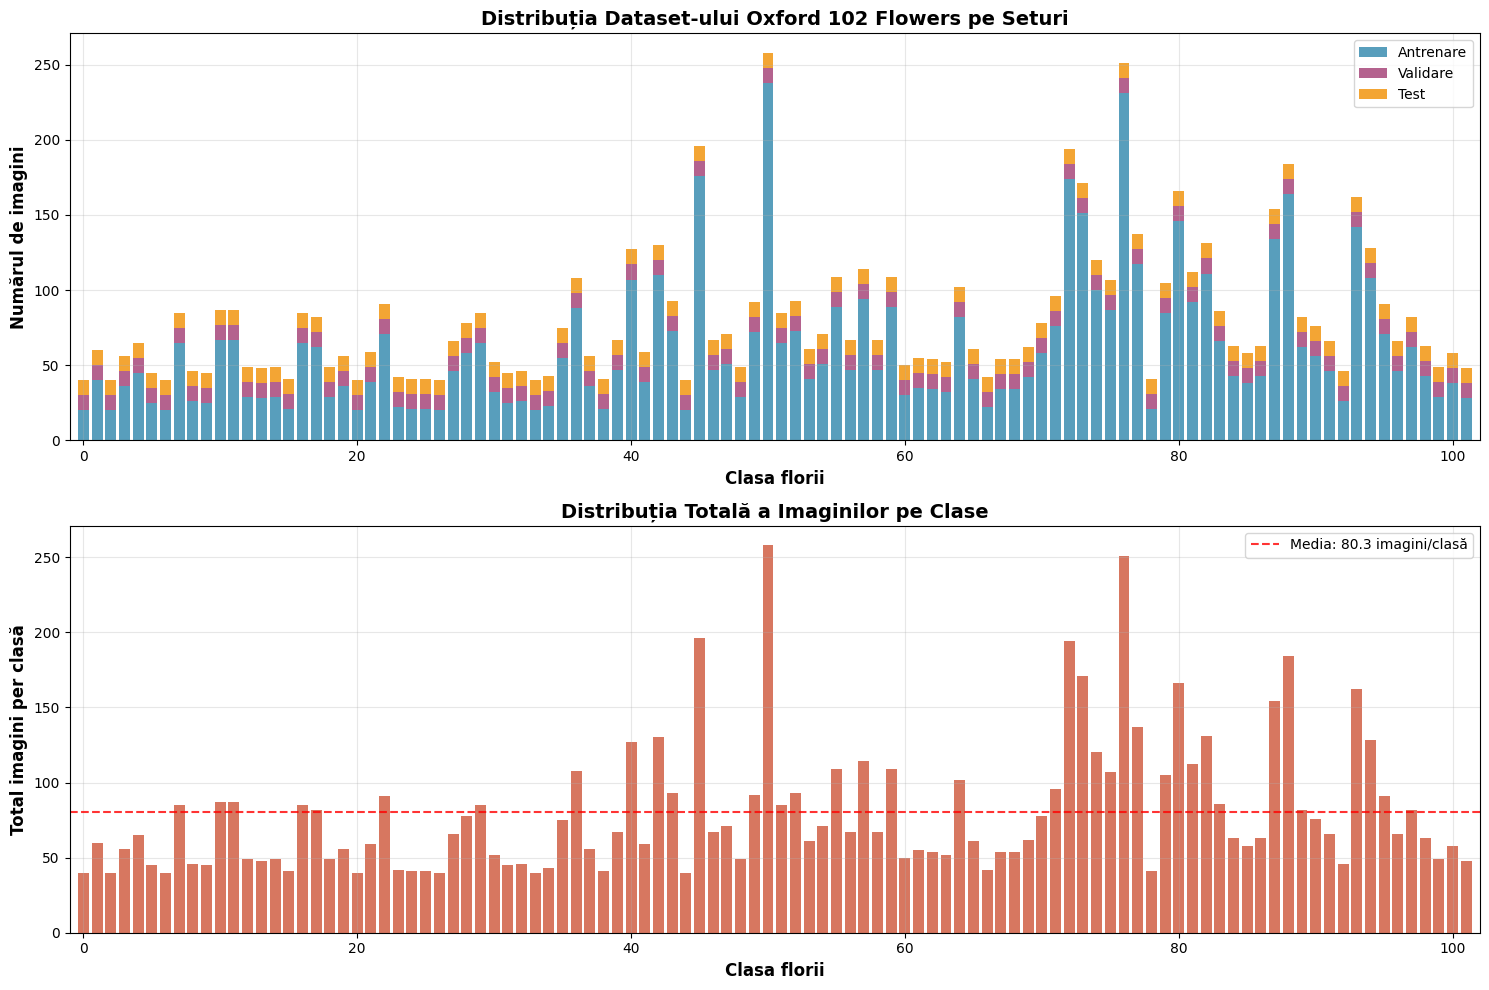

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import collections

def genereaza_dataset_distribution():
    train_labels = []
    val_labels = []
    test_labels = []

    for _, label in train_set:
        train_labels.append(label.numpy())

    for _, label in val_set:
        val_labels.append(label.numpy())

    for _, label in test_set:
        test_labels.append(label.numpy())

    train_dist = collections.Counter(train_labels)
    val_dist = collections.Counter(val_labels)
    test_dist = collections.Counter(test_labels)

    classes = list(range(num_classes))
    train_counts = [train_dist.get(i, 0) for i in classes]
    val_counts = [val_dist.get(i, 0) for i in classes]
    test_counts = [test_dist.get(i, 0) for i in classes]

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))

    width = 0.8
    ax1.bar(classes, train_counts, width, label='Antrenare', alpha=0.8, color='#2E86AB')
    ax1.bar(classes, val_counts, width, bottom=train_counts, label='Validare', alpha=0.8, color='#A23B72')
    ax1.bar(classes, test_counts, width, bottom=np.array(train_counts)+np.array(val_counts),
            label='Test', alpha=0.8, color='#F18F01')

    ax1.set_xlabel('Clasa florii', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Numărul de imagini', fontsize=12, fontweight='bold')
    ax1.set_title('Distribuția Dataset-ului Oxford 102 Flowers pe Seturi', fontsize=14, fontweight='bold')
    ax1.legend(fontsize=10)
    ax1.grid(True, alpha=0.3)
    ax1.set_xlim(-1, num_classes)

    total_counts = np.array(train_counts) + np.array(val_counts) + np.array(test_counts)

    ax2.bar(classes, total_counts, width=0.8, color='#C73E1D', alpha=0.7)
    ax2.set_xlabel('Clasa florii', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Total imagini per clasă', fontsize=12, fontweight='bold')
    ax2.set_title('Distribuția Totală a Imaginilor pe Clase', fontsize=14, fontweight='bold')
    ax2.grid(True, alpha=0.3)
    ax2.set_xlim(-1, num_classes)

    ax2.axhline(y=np.mean(total_counts), color='red', linestyle='--', alpha=0.8,
                label=f'Media: {np.mean(total_counts):.1f} imagini/clasă')
    ax2.legend()

    plt.tight_layout()

    plt.savefig('dataset_distribution.png', dpi=300, bbox_inches='tight',
                facecolor='white', edgecolor='none')
    plt.show()

genereaza_dataset_distribution()

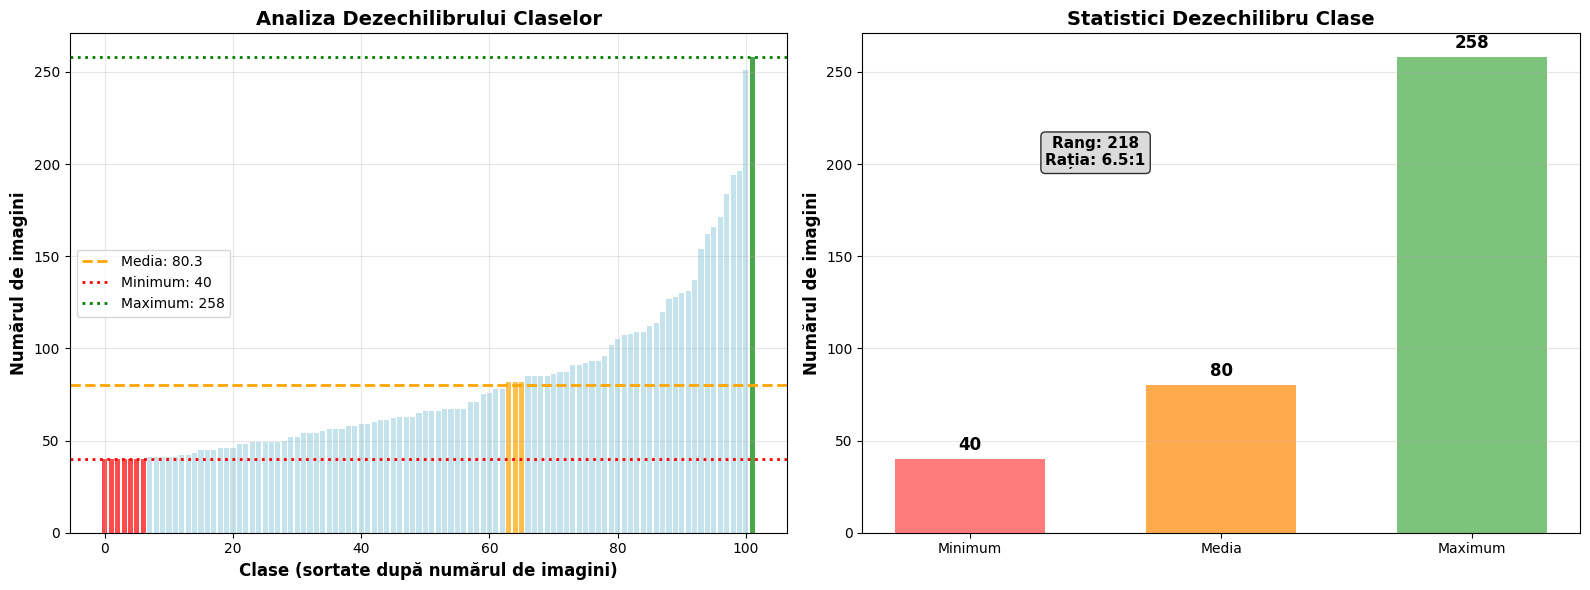

In [13]:
import matplotlib.pyplot as plt
import numpy as np
import collections

def genereaza_class_imbalance():
    train_labels = []
    val_labels = []
    test_labels = []

    for _, label in train_set:
        train_labels.append(label.numpy())

    for _, label in val_set:
        val_labels.append(label.numpy())

    for _, label in test_set:
        test_labels.append(label.numpy())

    train_dist = collections.Counter(train_labels)
    val_dist = collections.Counter(val_labels)
    test_dist = collections.Counter(test_labels)

    classes = list(range(num_classes))
    train_counts = [train_dist.get(i, 0) for i in classes]
    val_counts = [val_dist.get(i, 0) for i in classes]
    test_counts = [test_dist.get(i, 0) for i in classes]

    total_counts = np.array(train_counts) + np.array(val_counts) + np.array(test_counts)

    min_count = np.min(total_counts)
    max_count = np.max(total_counts)
    mean_count = np.mean(total_counts)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    sorted_indices = np.argsort(total_counts)
    sorted_counts = total_counts[sorted_indices]

    colors = ['red' if count == min_count else 'green' if count == max_count else 'orange' if abs(count - mean_count) < 2 else 'lightblue' for count in sorted_counts]

    ax1.bar(range(len(sorted_counts)), sorted_counts, color=colors, alpha=0.7)
    ax1.axhline(y=mean_count, color='orange', linestyle='--', linewidth=2, label=f'Media: {mean_count:.1f}')
    ax1.axhline(y=min_count, color='red', linestyle=':', linewidth=2, label=f'Minimum: {min_count}')
    ax1.axhline(y=max_count, color='green', linestyle=':', linewidth=2, label=f'Maximum: {max_count}')

    ax1.set_xlabel('Clase (sortate după numărul de imagini)', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Numărul de imagini', fontsize=12, fontweight='bold')
    ax1.set_title('Analiza Dezechilibrului Claselor', fontsize=14, fontweight='bold')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    stats_data = [min_count, mean_count, max_count]
    stats_labels = ['Minimum', 'Media', 'Maximum']
    bar_colors = ['#ff4444', '#ff8800', '#44aa44']

    bars = ax2.bar(stats_labels, stats_data, color=bar_colors, alpha=0.7, width=0.6)

    for bar, value in zip(bars, stats_data):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height + max_count*0.01,
                f'{value:.0f}', ha='center', va='bottom', fontweight='bold', fontsize=12)

    ax2.set_ylabel('Numărul de imagini', fontsize=12, fontweight='bold')
    ax2.set_title('Statistici Dezechilibru Clase', fontsize=14, fontweight='bold')
    ax2.grid(True, alpha=0.3, axis='y')

    range_val = max_count - min_count
    imbalance_ratio = max_count / min_count if min_count > 0 else float('inf')

    ax2.text(0.5, max_count * 0.8, f'Rang: {range_val}\nRația: {imbalance_ratio:.1f}:1',
             transform=ax2.transData, ha='center', va='center',
             bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray", alpha=0.8),
             fontsize=11, fontweight='bold')

    plt.tight_layout()
    plt.savefig('class_imbalance.png', dpi=300, bbox_inches='tight',
                facecolor='white', edgecolor='none')
    plt.show()

genereaza_class_imbalance()

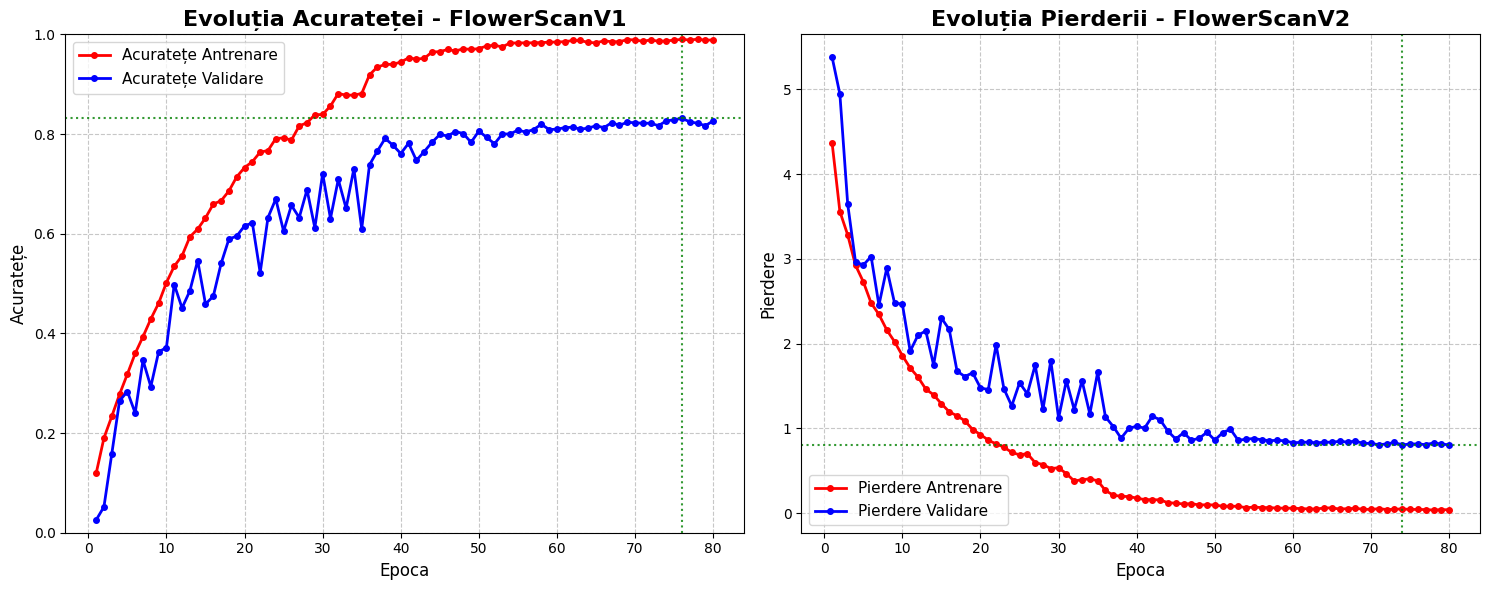

In [15]:
def vizualizare_istorie_cnn_v2(istoric):
    acuratete = istoric.history['accuracy']
    val_acuratete = istoric.history['val_accuracy']
    pierdere = istoric.history['loss']
    val_pierdere = istoric.history['val_loss']
    epoci = range(1, len(acuratete) + 1)

    plt.figure(figsize=(15, 6))

    plt.subplot(1, 2, 1)
    plt.plot(epoci, acuratete, 'ro-', label='Acuratețe Antrenare', linewidth=2, markersize=4)
    plt.plot(epoci, val_acuratete, 'bo-', label='Acuratețe Validare', linewidth=2, markersize=4)
    plt.title('Evoluția Acurateței - FlowerScanV1', fontsize=16, fontweight='bold')
    plt.xlabel('Epoca', fontsize=12)
    plt.ylabel('Acuratețe', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(fontsize=11)
    plt.ylim(0, 1)

    max_val_acc = max(val_acuratete)
    max_epoch = val_acuratete.index(max_val_acc) + 1
    plt.axhline(y=max_val_acc, color='green', linestyle=':', alpha=0.8,
                label=f'Max Val Acc: {max_val_acc:.3f}')
    plt.axvline(x=max_epoch, color='green', linestyle=':', alpha=0.8)

    plt.subplot(1, 2, 2)
    plt.plot(epoci, pierdere, 'ro-', label='Pierdere Antrenare', linewidth=2, markersize=4)
    plt.plot(epoci, val_pierdere, 'bo-', label='Pierdere Validare', linewidth=2, markersize=4)
    plt.title('Evoluția Pierderii - FlowerScanV2', fontsize=16, fontweight='bold')
    plt.xlabel('Epoca', fontsize=12)
    plt.ylabel('Pierdere', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(fontsize=11)

    min_val_loss = min(val_pierdere)
    min_epoch = val_pierdere.index(min_val_loss) + 1
    plt.axhline(y=min_val_loss, color='green', linestyle=':', alpha=0.8,
                label=f'Min Val Loss: {min_val_loss:.3f}')
    plt.axvline(x=min_epoch, color='green', linestyle=':', alpha=0.8)

    plt.tight_layout()
    plt.savefig('cnn_v2_training_history.png', dpi=300, bbox_inches='tight',
                facecolor='white', edgecolor='none')
    plt.show()

vizualizare_istorie_cnn_v2(history)